### 암 재발 가능성

In [5]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [6]:
origin = read_excel("https://data.hossam.kr/F03/biostat.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  156 non-null    int64         
 1   age                 156 non-null    int64         
 2   sex                 156 non-null    int64         
 3   weight              156 non-null    float64       
 4   OP_date             156 non-null    datetime64[ns]
 5   Recur               156 non-null    int64         
 6   Recur_1y            156 non-null    int64         
 7   Recur_date          156 non-null    datetime64[ns]
 8   SBP                 156 non-null    float64       
 9   CA19.9              156 non-null    float64       
 10  CRP                 156 non-null    float64       
 11  CEA                 156 non-null    float64       
 12  post.CEA            156 non-null    float64       
 13  stage               156 non-null    int64         

|필드명	|설명|	비고|
|--|--|--|
id	|고유번호	
age	|나이	
sex|	성별|	0=여성, 1=남성
weight	|체중	
OP_date	|수술 날짜	
Recur|	재발 여부|	1=재발, 0=마지막 관찰시점까지 재발 안함
Recur_1y	|1년 내 재발 여부 |	1=1년 내 재발, 0=1년 내 재발 안함
Recur_date	|재발 날짜|	재발하지 않은 환자의 경우 마지막 검사 날짜
SBP	|수축기 혈압	
CA19.9	|종양표지자의 일종인 CA19-9값	
CRP	|C-반응 단백질 수치	
CEA	|종용표지자의 일종인 CEA 값	
post.CEA|	수술 직후 CEA 값	
stage	|암의 병기	|1, 2, 3
smoking	|흡연 여부	|1=흡연, 0=비흡연
obesity|	비만 여부	|1=비만, 0=정상
post.CA19.9	수술 직후| CA19-9값	
post.CA19.9.binary	|post.CA19.9가 37 초과이면 1, 37 이하이면 0	
post.CA19.9.3grp	|post.CA19.9가 37 이하이면 1, 37초과 100 이히면 2, 70 초과이면 3	


In [7]:
origin.shape

(156, 19)

In [13]:
origin.isna().sum()

id                    0
age                   0
sex                   0
weight                0
OP_date               0
Recur                 0
Recur_1y              0
Recur_date            0
SBP                   0
CA19.9                0
CRP                   0
CEA                   0
post.CEA              0
stage                 0
smoking               0
obesity               0
post.CA19.9           0
post.CA19.9.binary    0
post.CA19.9.3grp      0
dtype: int64

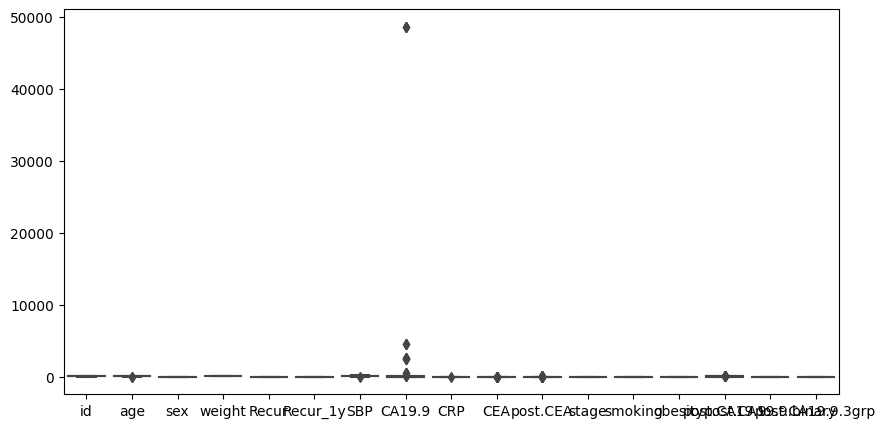

In [29]:
# 상자 그림으로 이상치 확인
plt.figure(figsize=(10, 5))
sb.boxplot(data=origin)
plt.show()
plt.close()


In [32]:
origin.describe()

,id,age,sex,weight,OP_date,Recur,Recur_1y,Recur_date,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
count,156.000000,156.000000,156.000000,156.000000,156,156.000000,156.000000,156,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,78.500000,56.858974,0.653846,68.125624,2015-07-10 21:41:32.307692288,0.538462,0.346154,2017-09-24 10:00:00,115.898871,1158.631410,3.062821,3.930128,5.363462,2.269231,0.262821,0.384615,48.193259,0.608974,1.698718
min,1.000000,25.000000,0.000000,40.000000,2011-12-23 00:00:00,0.000000,0.000000,2012-04-05 00:00:00,5.629379,1.000000,0.100000,0.300000,0.100000,1.000000,0.000000,0.000000,30.760115,0.000000,1.000000
25%,39.750000,50.000000,0.000000,58.257205,2014-08-06 12:00:00,0.000000,0.000000,2016-06-09 18:00:00,89.074804,10.400000,0.100000,1.500000,0.600000,2.000000,0.000000,0.000000,34.908674,0.000000,1.000000
50%,78.500000,58.000000,1.000000,69.084391,2015-10-02 00:00:00,1.000000,0.000000,2018-03-12 00:00:00,114.647853,23.150000,1.300000,2.400000,1.650000,2.500000,0.000000,0.000000,41.285774,1.000000,2.000000
75%,117.250000,65.000000,1.000000,80.053547,2016-08-09 00:00:00,1.000000,1.000000,2019-10-04 18:00:00,144.331917,61.725000,4.850000,4.525000,4.800000,3.000000,1.000000,1.000000,51.216016,1.000000,2.000000
max,156.000000,82.000000,1.000000,95.000000,2017-11-17 00:00:00,1.000000,1.000000,2020-01-13 00:00:00,206.847716,48599.800000,12.300000,20.400000,118.500000,3.000000,1.000000,1.000000,174.433426,1.000000,3.000000
std,45.177428,12.790343,0.477275,14.467480,NaN,0.500124,0.477275,NaN,37.701583,6709.440806,3.550361,4.135752,12.846207,0.813960,0.441583,0.488071,22.921452,0.489552,0.626510


In [38]:

origin_CA19 = max(origin["CA19.9"])
origin_CA19

TypeError: 'float' object is not iterable

In [28]:
origin_df = get_dummies(origin, columns=['post.CA19.9.3grp','stage'], drop_first=True, dtype='int')
origin_df.head()

,id,age,sex,weight,OP_date,Recur,Recur_1y,Recur_date,SBP,CA19.9,...,CEA,post.CEA,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp_2,post.CA19.9.3grp_3,stage_2,stage_3
0,1,82,1,73.994588,2014-07-10,1,0,2015-08-12,144.286869,4490.5,...,3.0,5.1,1,1,36.795194,0,0,0,0,1
1,2,50,0,64.819694,2013-05-08,0,0,2018-07-07,108.590964,36.7,...,1.1,1.5,1,0,32.765043,0,0,0,0,1
2,3,28,1,63.204675,2016-05-06,0,0,2020-01-13,5.629379,36.7,...,10.7,12.4,1,0,31.133072,0,0,0,0,1
3,4,35,1,52.499192,2015-11-24,1,0,2017-08-07,143.931300,64.9,...,1.3,0.4,1,1,36.134051,0,0,0,0,1
4,5,49,1,72.766264,2015-02-12,1,0,2016-06-02,172.653143,38.2,...,3.7,0.4,1,0,33.921657,0,0,0,0,1


In [27]:
# 로지스틱 회귀 분석의 피처로 사용할 데이터를 평균이 0 분산이 1이 되는 정규 분포 형태로 맞춘다. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler

In [23]:
x = origin.drop(['Recur_1y'],axis = 1)
x.head()

,id,age,sex,weight,OP_date,Recur,Recur_date,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
0,1,82,1,73.994588,2014-07-10,1,2015-08-12,144.286869,4490.5,0.1,3.0,5.1,3,1,1,36.795194,0,1
1,2,50,0,64.819694,2013-05-08,0,2018-07-07,108.590964,36.7,0.1,1.1,1.5,3,1,0,32.765043,0,1
2,3,28,1,63.204675,2016-05-06,0,2020-01-13,5.629379,36.7,0.1,10.7,12.4,3,1,0,31.133072,0,1
3,4,35,1,52.499192,2015-11-24,1,2017-08-07,143.931300,64.9,1.3,1.3,0.4,3,1,1,36.134051,0,1
4,5,49,1,72.766264,2015-02-12,1,2016-06-02,172.653143,38.2,10.7,3.7,0.4,3,1,0,33.921657,0,1


In [25]:
y = origin['Recur_1y']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Recur_1y, dtype: int64

In [ ]:

# 스케일링


In [26]:
# x_scaled = scaler.fit_transform(x)


TypeError: wrapped() missing 1 required positional argument: 'X'

In [ ]:
b_cancer_scaled = scaler.fit_transform(origin.data)# 피처로 사용할 데이터에 대해 정규 분포 스케일링을 수행하여 저장한다. 
print(origin.data[0]) 
print(b_cancer_scaled[0]) # 값이 조정된거 확인 


# 로지스틱 회귀를 이용하여 분석 모델 구축하기 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# x,y 설정하기 
y = b_cancer_df['diagnosis']
x = b_cancer_scaled # 정규 분포로 스케일링 

# 훈련용 데이터와 평가용 데이터 분할하기
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state = 0)

# 로지스틱 회귀 분석 : 모델 객체 생성
lr_b_cancer = LogisticRegression() 

# 로지스틱 회귀 분석 : 모델 훈련 학습 데이터로 모델 학습을 수행(fit)한다.
lr_b_cancer.fit(x_train, y_train)

# 로지스틱 회귀 분석 평가 데이터에 대한 예측 수행. x_test를 가지고 예측을 수행predict 수행하여 예측값 y_predict를 구한다)
y_predict = lr_b_cancer.predict(x_test)

# 생성한 모델의 성능 확인하기

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score 
# 평가 지수 계산을 제공하는 모듈 임포트

# 오차 행렬
# 평가를 위해 7:3으로 분할한 test데이터에 대해 이진 분류의 성능 평가 기본이 되는 오차 행렬을 구한다. 
confusion_matrix(y_test,y_predict)

# 성능 평가 지표인 정확도, 정밀도, 재현율, F1스코어, ROC-AUC 스코어를 구한다.
accuracy = accuracy_score(y_test,y_predict)
precision = precision_score(y_test,y_predict)
recall = recall_score(y_test,y_predict)
f1 = f1_score(y_test,y_predict)
roc_auc = roc_auc_score(y_test,y_predict)
print('정확도:{},정밀도:{},재현율:{},F1:{}'.format(accuracy,precision,recall,f1))

print('ROC_AUC:',roc_auc)
